# CS6650 (Web M.Tech): Smart Sensing for Internet of Things
#### Homework 2 (Part B) (Diwali 2024 Semester)
Submission Deadline : Nov 29th, 2024

---
Name: `Dipendu Ghosh`

Roll No: `CS23M509`

Email: `CS23M509@smail.iitm.ac.in`

---

### Localization of IoT Devices

<div style="display:flex; overflow: hidden;">
  <div style="margin:20px;">
    <p>Consider a 2D-grid of MxN cells where we want to locate an IoT device (marked as N) using multilateration. The lower-left corner cell can be treated as the origin (0,0) while the location of the top-right cell is (M, N). Assume that all anchors (A1, A2, and A3) are kept at known locations.</p>
  </div>
</div>

---

In [10]:
import random
import csv
import os
import math
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import lmfit
from tabulate import tabulate
import statistics

### Task 1: Dataset Generation.

<div style="display:flex; overflow: hidden;">
  <img src="./images/image1.jpg" width="400" height="250" style="margin:20px; object-fit: cover; object-position: top;">
  <div style="margin:20px;">
  <p> Simulate grid of size 100x100. Consider 3 anchors. [10 points]</p>
    <p>a. Randomly generate 100 unique anchor location sets and for each randomly generated anchor location set, generate 50 random unique node locations (programming hint: use a Set ADT while generating the data). All such location points should be within the simulated grid’s bounding box. Write this data to a file, &lt;true_locations.csv&gt;
    
[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>1</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)


[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>2</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)

      …      …       …       …      …      …

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>100</sup>, (NX<sub>1</sub>, NY<sub>1</sub>), .. (NX<sub>50</sub>, NY<sub>50</sub>)
    </p>
    <p></p>
    <p>b. Generate the range values for each node location to the respective anchors and write them to a file &lt;pure_ranges.csv&gt;

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>1</sup>,  .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>1</sup>, .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>50</sup>

      …      …       …       …      …      …

[(x<sub>1</sub>, y<sub>1</sub>), (x<sub>2</sub>, y<sub>2</sub>), (x<sub>3</sub>, y<sub>3</sub>)]<sup>100</sup>,  .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>1</sup>, .. (R<sub>1</sub>,R<sub>2</sub>,R<sub>3</sub>)<sup>50</sup>
    </p>
    <p></p>
    <p>c. Now generate noisy range values for each node location by adding Gaussian noise to each pure range value as in &lt;pure_ranges.csv&gt;. R<sub>noisy</sub> = R<sub>pure</sub> + N(μ,σ). Generate three datasets, for μ = 0.5, 1 and 2. Assume σ = 0.1 for all cases. Write these data into three files &lt;noisy_ranges_05.csv&gt;, &lt;noisy_ranges_1.csv&gt; and &lt;noisy_ranges_2.csv&gt;
    </p>
  </div>
</div>

In [11]:
##==============================================================PART B. 1:a===========================================================================##

def generate_coordinates(count, lower_bound, upper_bound, existing_coordinates):
    coordinates = set()
    while len(coordinates) < count:
        x = random.randint(lower_bound, upper_bound)
        y = random.randint(lower_bound, upper_bound)
        if (x, y) not in existing_coordinates:
            coordinates.add((x, y))
            existing_coordinates.add((x, y))
    return coordinates

def generate_true_locations_data(count, lower_bound, upper_bound):
    true_locations_data = []
    all_generated_coordinates = set()
    
    for i in range(count):
        anchor_set = generate_coordinates(3, lower_bound, upper_bound, all_generated_coordinates)
        
        node_set = generate_coordinates(50, lower_bound, upper_bound, all_generated_coordinates)
        
        true_locations_data.append({
            "Anchor Set": list(anchor_set),
            "Node Set": list(node_set)
        })
    
    return true_locations_data

def write_true_locations_to_csv(true_locations_data, file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
    
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        for idx, data in enumerate(true_locations_data):
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({x}, {y})" for (x, y) in data["Node Set"]]
            writer.writerow(row)

true_locations_file_path = 'dipendu_data/true_locations.csv'
if os.path.exists(true_locations_file_path):
    os.remove(true_locations_file_path)

true_locations_data = generate_true_locations_data(100, 0, 100)

write_true_locations_to_csv(true_locations_data, true_locations_file_path)

print(f"PART B. 1:a. Generated anchor location and corresponding node location. Data has been written to \"{true_locations_file_path}\"")

##==============================================================PART B. 1:b===========================================================================##

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def parse_coordinate(coord_str):
    return tuple(map(int, coord_str.strip('()').split(', ')))

def generate_pure_ranges_data(true_locations_file_path):
    pure_ranges_data = []
    
    with open(true_locations_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        header = next(reader)
        
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]
        node_indices = [header.index(f"Node_{i+1}") for i in range(50)]
        
        for row in reader:
            anchors = [parse_coordinate(row[anchor_indices[i]]) for i in range(3)]
            
            nodes = [parse_coordinate(row[node_indices[i]]) for i in range(50)]
            
            ranges = []
            for node in nodes:
                node_ranges = tuple(euclidean_distance(node[0], node[1], anchor[0], anchor[1]) for anchor in anchors)
                ranges.append(node_ranges)
            
            pure_ranges_data.append({
                "anchors": anchors,
                "ranges": ranges
            })
    
    return pure_ranges_data

def write_pure_ranges_to_csv(pure_ranges_data, pure_ranges_file_path):
    if os.path.exists(pure_ranges_file_path):
        os.remove(pure_ranges_file_path)
    
    with open(pure_ranges_file_path, mode='w', newline='') as outfile:
        writer = csv.writer(outfile)
        
        output_header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{i+1}" for i in range(50)]
        writer.writerow(output_header)
        
        for data in pure_ranges_data:
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in data["anchors"]]
            
            range_strs = [f"({r[0]:.2f}, {r[1]:.2f}, {r[2]:.2f})" for r in data["ranges"]]
            
            output_row = anchor_strs + range_strs
            writer.writerow(output_row)

pure_ranges_file_path = 'dipendu_data/pure_ranges.csv'
if os.path.exists(pure_ranges_file_path):
    os.remove(pure_ranges_file_path)

pure_ranges_data = generate_pure_ranges_data(true_locations_file_path)

write_pure_ranges_to_csv(pure_ranges_data, pure_ranges_file_path)

print(f"PART B. 1:b. Generated pure ange values for each node location with repect to each anchor location. Data has been written to \"{pure_ranges_file_path}\"")

##==============================================================PART B. 1:c===========================================================================##

def gaussian_noise(mu, sigma):
    random_value = np.random.normal(mu, sigma)
    return random_value

def generate_noisy_ranges(pure_ranges_file_path):
    noisy_range_05 = []
    noisy_range_1 = []
    noisy_range_2 = []
    
    with open(pure_ranges_file_path, mode='r') as infile:
        reader = csv.reader(infile)
        header = next(reader)
        
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]
        range_indices = [header.index(f"Node_{i+1}") for i in range(50)]
        
        for row in reader:
            anchors = [tuple(map(int, row[anchor_indices[i]].strip('()').split(', '))) for i in range(3)]
            
            ranges = [tuple(map(float, row[range_indices[i]].strip('()').split(', '))) for i in range(50)]
            
            noisy_ranges_05_row = []
            noisy_ranges_1_row = []
            noisy_ranges_2_row = []
            
            for node_range in ranges:
                noisy_range_05_tuple = []
                noisy_range_1_tuple = []
                noisy_range_2_tuple = []
                
                for range_val in node_range:
                    noisy_range_05_tuple.append(range_val + gaussian_noise(mu=0.5, sigma=0.1))
                    noisy_range_1_tuple.append(range_val + gaussian_noise(mu=1, sigma=0.1))
                    noisy_range_2_tuple.append(range_val + gaussian_noise(mu=2, sigma=0.1))
                
                noisy_ranges_05_row.append(tuple(noisy_range_05_tuple))
                noisy_ranges_1_row.append(tuple(noisy_range_1_tuple))
                noisy_ranges_2_row.append(tuple(noisy_range_2_tuple))
            
            noisy_range_05.append({
                "anchors": anchors,
                "noisy_ranges": noisy_ranges_05_row
            })
            
            noisy_range_1.append({
                "anchors": anchors,
                "noisy_ranges": noisy_ranges_1_row
            })
            
            noisy_range_2.append({
                "anchors": anchors,
                "noisy_ranges": noisy_ranges_2_row
            })
    
    return noisy_range_05, noisy_range_1, noisy_range_2

def write_noisy_ranges_to_csv(noisy_range_data, output_filename):
    with open(output_filename, mode='w', newline='') as outfile:
        writer = csv.writer(outfile)
        
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{i+1}" for i in range(50)]
        writer.writerow(header)
        
        for data in noisy_range_data:
            anchor_strs = [f"({anchor[0]}, {anchor[1]})" for anchor in data["anchors"]]
            
            range_strs = [f"({r[0]:.2f}, {r[1]:.2f}, {r[2]:.2f})" for r in data["noisy_ranges"]]
            
            output_row = anchor_strs + range_strs
            writer.writerow(output_row)


noisy_ranges_05_file_path = 'dipendu_data/noisy_ranges_05.csv'
if os.path.exists(noisy_ranges_05_file_path):
    os.remove(noisy_ranges_05_file_path)
noisy_ranges_1_file_path = 'dipendu_data/noisy_ranges_1.csv'
if os.path.exists(noisy_ranges_1_file_path):
    os.remove(noisy_ranges_1_file_path)
noisy_ranges_2_file_path = 'dipendu_data/noisy_ranges_2.csv'
if os.path.exists(noisy_ranges_2_file_path):
    os.remove(noisy_ranges_2_file_path)

noisy_range_05, noisy_range_1, noisy_range_2 = generate_noisy_ranges(pure_ranges_file_path)

write_noisy_ranges_to_csv(noisy_range_05, noisy_ranges_05_file_path)
write_noisy_ranges_to_csv(noisy_range_1, noisy_ranges_1_file_path)
write_noisy_ranges_to_csv(noisy_range_2, noisy_ranges_2_file_path)

print(f"PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 0.5, σ = 0.1. Data has been written to \"{noisy_ranges_05_file_path}\"")
print(f"PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 1, σ = 0.1. Data has been written to \"{noisy_ranges_1_file_path}\"")
print(f"PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 2, σ = 0.1. Data has been written to \"{noisy_ranges_2_file_path}\"")

PART B. 1:a. Generated anchor location and corresponding node location. Data has been written to "dipendu_data/true_locations.csv"
PART B. 1:b. Generated pure ange values for each node location with repect to each anchor location. Data has been written to "dipendu_data/pure_ranges.csv"
PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 0.5, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_05.csv"
PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 1, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_1.csv"
PART B. 1:c. Generated noisy range values for each node location with repect to each anchor location for μ = 2, σ = 0.1. Data has been written to "dipendu_data/noisy_ranges_2.csv"


### Task 2: Range Equations. 

<div style="display:flex; overflow: hidden;">
  <img src="./images/image2.jpg" width="400" height="250" style="margin:20px; object-fit: cover; object-position: top;">
  <div style="margin:20px;">
  <p> Generate two random numbers, A in [1, 100] and B in [1, 50]. Choose the A<sup>th</sup> line and the B<sup>th</sup> node location from the files in (a), (b), and (c). [20 + 10 points]</p>
    <p>a. Form the cost function (use root mean square error) using the three range equations for that particular node and anchor locations. Evaluate the “cost value” for all the 100x100 cells for &lt;pure_ranges.csv&gt;, &lt;noisy_ranges_05.csv&gt;, &lt;noisy_ranges_1.csv&gt; and &lt;noisy_ranges_2.csv&gt;. While
evaluating your cost function put (X = i and Y = j) where i and j are integers in [0,99].
Visualize the normalized cost values (scale: 0 to 1) in the form of a heatmap. Plot the 4 heatmaps. Don’t interpolate your heatmaps.
    </p>
    <p></p>
    <p>b. Summarize your observations. Did you realize the fact that we are trying to use a brute-force approach to scan all possible cells for the solution? Is the cell with the global minima near (or, how far from) the actual node location? (Cost value = 0 for non-noisy case) Are there local minima present in the noisy cases?
    </p>
  </div>
</div>



Anchors Co-ordinates -> [(41, 39), (45, 14), (63, 83)]
Node Co-ordinates -> (64, 61)
Pure Ranges Minima Co-ordinates -> (64, 61)
Noisy Ranges 0.5 Minima Co-ordinates -> (65, 61)
Noisy Ranges 1 Minima Co-ordinates -> (66, 61)
Noisy Ranges 2 Minima Co-ordinates -> (68, 60)


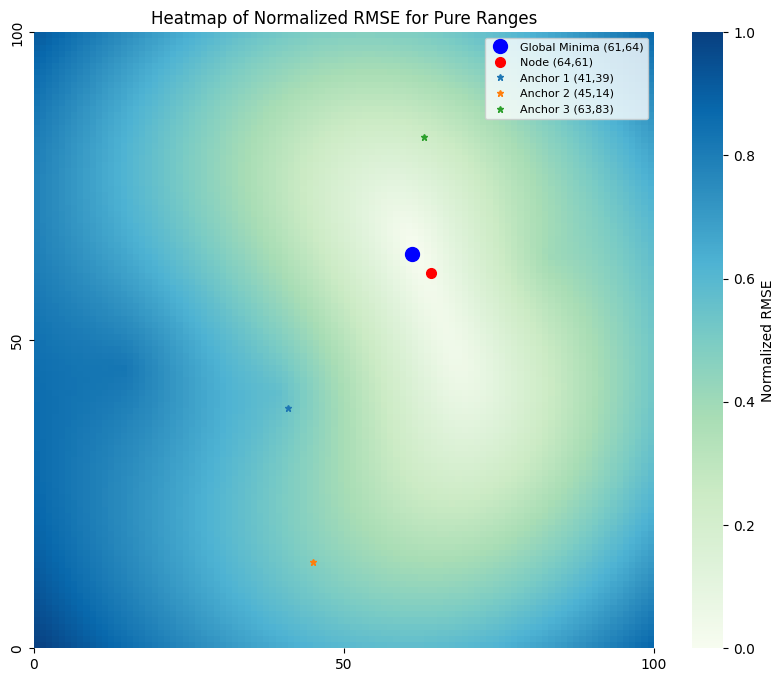

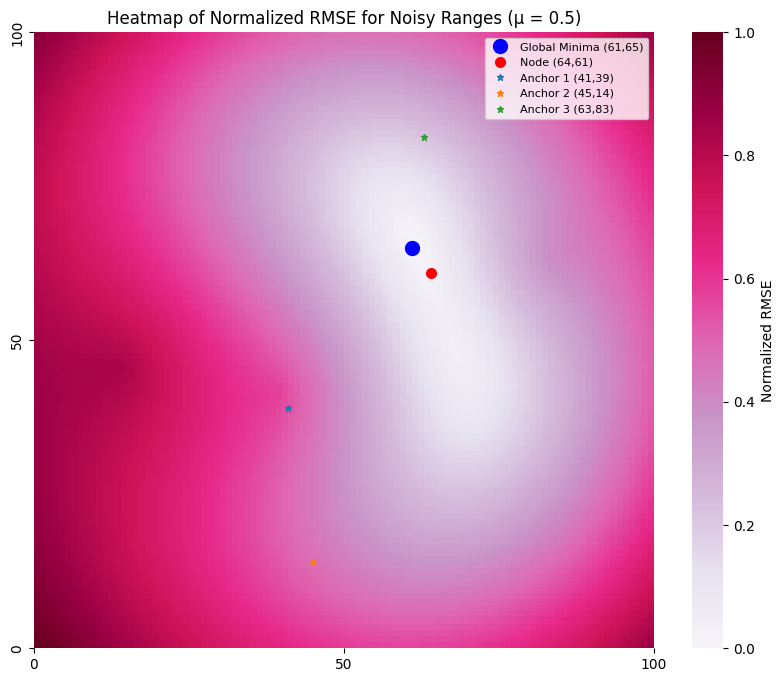

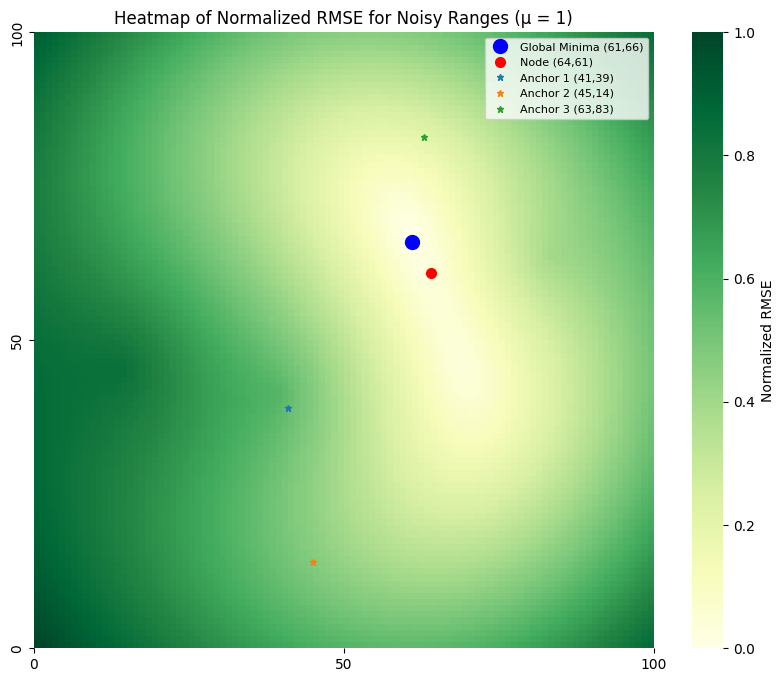

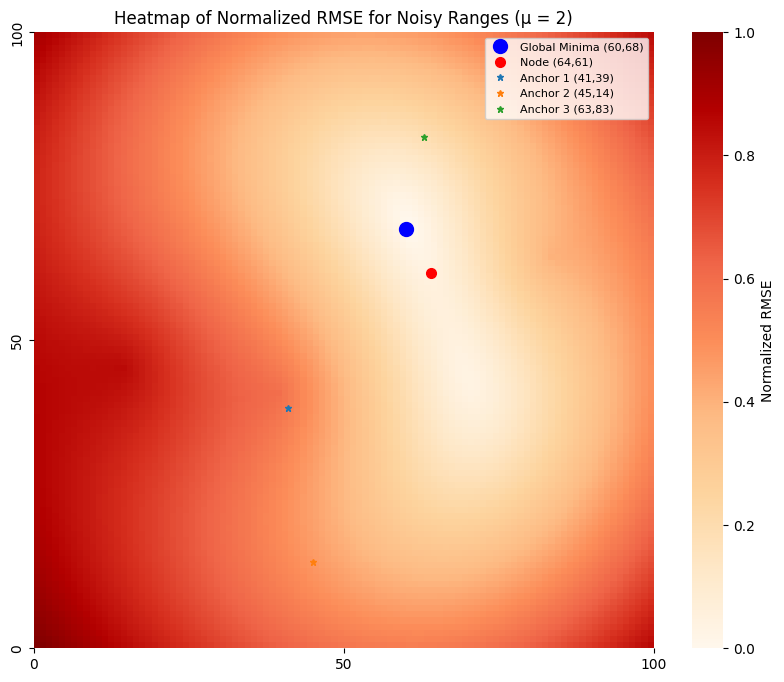

In [12]:
def euclidean_distance(coord1, coord2):
    return np.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def calculate_rmse(candidate, anchors, ranges):
    estimated_distances = [euclidean_distance(candidate, anchor) for anchor in anchors]
    rmse = np.sqrt(np.mean([(estimated_distances[k] - ranges[k])**2 for k in range(3)]))
    return rmse

def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)

def find_global_minima(matrix):
    min_value = float('inf')
    min_index = (-1, -1)

    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value < min_value:
                min_value = value
                min_index = (i, j)
    
    return min_index, min_value


def plot_heatmap(value, min_index, title, color):
    plt.figure(figsize=(10, 8))
    sns.heatmap(value, cmap=color, alpha=1, cbar=True, cbar_kws={'label': 'Normalized RMSE'}, vmin=0, vmax=1)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.xticks(ticks=[0, 50, 100], labels=['0', '50', '100'])
    plt.yticks(ticks=[0, 50, 100], labels=['0', '50', '100'])
    plt.plot(min_index[1], min_index[0], 'bo', markersize=10, label=f"Global Minima ({min_index[1]},{min_index[0]})")
    plt.plot(node[0], node[1], 'ro', markersize=7, label=f"Node ({node[0]},{node[1]})")
    for i, anchor in enumerate(anchors, start=1):
        plt.plot(anchor[0], anchor[1], '*', markersize=5, label=f"Anchor {i} ({anchor[0]},{anchor[1]})")
    plt.legend(fontsize=8)
    plt.show()

true_locations = pd.read_csv(true_locations_file_path, header=0)
pure_ranges = pd.read_csv(pure_ranges_file_path, header=0)
noisy_ranges_05 = pd.read_csv(noisy_ranges_05_file_path, header=0)
noisy_ranges_1 = pd.read_csv(noisy_ranges_1_file_path, header=0)
noisy_ranges_2 = pd.read_csv(noisy_ranges_2_file_path, header=0)

A = random.randint(1, 100)
B = random.randint(1, 50)
A = A - 1
B = B - 1 + 3

anchors = [eval(true_locations.iloc[A, i]) for i in range(3)]
print(f"Anchors Co-ordinates -> {anchors}")
node = eval(true_locations.iloc[A, B])
print(f"Node Co-ordinates -> {node}")

pure_range = eval(pure_ranges.iloc[A, B])
noisy_range_05 = eval(noisy_ranges_05.iloc[A, B])
noisy_range_1 = eval(noisy_ranges_1.iloc[A, B])
noisy_range_2 = eval(noisy_ranges_2.iloc[A, B])

pure_ranges_cost_matrix = np.zeros((100, 100))
noisy_ranges_05_cost_matrix = np.zeros((100, 100))
noisy_ranges_1_cost_matrix = np.zeros((100, 100))
noisy_ranges_2_cost_matrix = np.zeros((100, 100))

for i in range(100):
    for j in range(100):
        candidate_location = (i, j)
        pure_ranges_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, pure_range)
        noisy_ranges_05_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_05)
        noisy_ranges_1_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_1)
        noisy_ranges_2_cost_matrix[i, j] = calculate_rmse(candidate_location, anchors, noisy_range_2)

pure_ranges_cost_matrix_file_path = 'dipendu_data/pure_ranges_cost_matrix.csv'
if os.path.exists(pure_ranges_cost_matrix_file_path):
    os.remove(pure_ranges_cost_matrix_file_path)
noisy_ranges_05_cost_matrix_file_path = 'dipendu_data/noisy_ranges_05_cost_matrix.csv'
if os.path.exists(noisy_ranges_05_cost_matrix_file_path):
    os.remove(noisy_ranges_05_cost_matrix_file_path)
noisy_ranges_1_cost_matrix_file_path = 'dipendu_data/noisy_ranges_1_cost_matrix.csv'
if os.path.exists(noisy_ranges_1_cost_matrix_file_path):
    os.remove(noisy_ranges_1_cost_matrix_file_path)
noisy_ranges_2_cost_matrix_file_path = 'dipendu_data/noisy_ranges_2_cost_matrix.csv'
if os.path.exists(noisy_ranges_2_cost_matrix_file_path):
    os.remove(noisy_ranges_2_cost_matrix_file_path)

np.savetxt(pure_ranges_cost_matrix_file_path, pure_ranges_cost_matrix, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_05_cost_matrix_file_path, noisy_ranges_05_cost_matrix, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_1_cost_matrix_file_path, noisy_ranges_1_cost_matrix, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_2_cost_matrix_file_path, noisy_ranges_2_cost_matrix, delimiter=",", fmt="%.5f")

pure_ranges_cost_matrix_normalized = normalize_matrix(pure_ranges_cost_matrix)
noisy_ranges_05_cost_matrix_normalized = normalize_matrix(noisy_ranges_05_cost_matrix)
noisy_ranges_1_cost_matrix_normalized = normalize_matrix(noisy_ranges_1_cost_matrix)
noisy_ranges_2_cost_matrix_normalized = normalize_matrix(noisy_ranges_2_cost_matrix)

pure_ranges_cost_matrix_normalized_file_path = 'dipendu_data/pure_ranges_cost_matrix_normalized.csv'
if os.path.exists(pure_ranges_cost_matrix_normalized_file_path):
    os.remove(pure_ranges_cost_matrix_normalized_file_path)
noisy_ranges_05_cost_matrix_normalized_file_path = 'dipendu_data/noisy_ranges_05_cost_matrix_normalized.csv'
if os.path.exists(noisy_ranges_05_cost_matrix_normalized_file_path):
    os.remove(noisy_ranges_05_cost_matrix_normalized_file_path)
noisy_ranges_1_cost_matrix_normalized_file_path = 'dipendu_data/noisy_ranges_1_cost_matrix_normalized.csv'
if os.path.exists(noisy_ranges_1_cost_matrix_normalized_file_path):
    os.remove(noisy_ranges_1_cost_matrix_normalized_file_path)
noisy_ranges_2_cost_matrix_normalized_file_path = 'dipendu_data/noisy_ranges_2_cost_matrix_normalized.csv'
if os.path.exists(noisy_ranges_2_cost_matrix_normalized_file_path):
    os.remove(noisy_ranges_2_cost_matrix_normalized_file_path)

np.savetxt(pure_ranges_cost_matrix_normalized_file_path, pure_ranges_cost_matrix_normalized, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_05_cost_matrix_normalized_file_path, noisy_ranges_05_cost_matrix_normalized, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_1_cost_matrix_normalized_file_path, noisy_ranges_1_cost_matrix_normalized, delimiter=",", fmt="%.5f")
np.savetxt(noisy_ranges_2_cost_matrix_normalized_file_path, noisy_ranges_2_cost_matrix_normalized, delimiter=",", fmt="%.5f")

pure_ranges_minima_index, pure_ranges_minima_value = find_global_minima(pure_ranges_cost_matrix_normalized)
noisy_ranges_05_minima_index, noisy_ranges_05_minima_value = find_global_minima(noisy_ranges_05_cost_matrix_normalized)
noisy_ranges_1_minima_index, noisy_ranges_1_minima_value = find_global_minima(noisy_ranges_1_cost_matrix_normalized)
noisy_ranges_2_minima_index, noisy_ranges_2_minima_value = find_global_minima(noisy_ranges_2_cost_matrix_normalized)

print(f"Pure Ranges Minima Co-ordinates -> {pure_ranges_minima_index}")
print(f"Noisy Ranges 0.5 Minima Co-ordinates -> {noisy_ranges_05_minima_index}")
print(f"Noisy Ranges 1 Minima Co-ordinates -> {noisy_ranges_1_minima_index}")
print(f"Noisy Ranges 2 Minima Co-ordinates -> {noisy_ranges_2_minima_index}")

plot_heatmap(pure_ranges_cost_matrix_normalized, pure_ranges_minima_index, 'Heatmap of Normalized RMSE for Pure Ranges', "GnBu")
plot_heatmap(noisy_ranges_05_cost_matrix_normalized, noisy_ranges_05_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 0.5)', "PuRd")
plot_heatmap(noisy_ranges_1_cost_matrix_normalized, noisy_ranges_1_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 1)', "YlGn")
plot_heatmap(noisy_ranges_2_cost_matrix_normalized, noisy_ranges_2_minima_index, 'Heatmap of Normalized RMSE for Noisy Ranges (μ = 2)', "OrRd")

### Task 3: Trilateration. 

<div style="display:flex; overflow: hidden;">
  <div style="margin:20px;">
    <p>Now use an optimizer to solve for the node location for all 100x50 node locations (pure + 3 noisy versions). If you are using python, use lmfit (https://lmfit.github.io/lmfit-py/). Round off the output of the solver to the nearest integer value, say if the solver outputs (50.69, 45.23) - round it off to (51, 45) for the estimated location cell. Also make sure the solver knows the limits of the solution (i.e., the bounding box). Write the solvers output into 4 files, &lt;pure_locs.csv&gt;, &lt;noisy_locs_05.csv&gt;, &lt;noisy_locs_1.csv&gt; and &lt;noisy_locs_2.csv&gt;. Compare the solved locations with the entries in &lt;true_locations.csv&gt; and compute the localization errors (euclidean distance between true and estimated location).
    </p>
    <p></p>
    <p>a. Plot 4 CDFs (each for the 5000 error values) on the same graph, to compare the 4 cases.
    <p>
For the 4 cases state the: 
</p><p>
(i) median error, </p><p>
(ii) 75th percentile error,</p><p>
(iii) 95th percentile error.
    </p>
  </div>
</div>



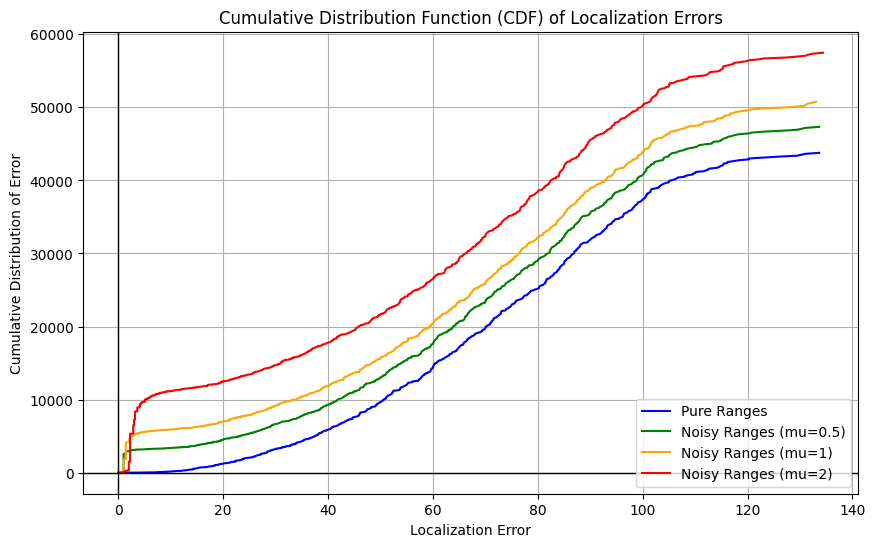

+-----------------------+----------------+-------------------------+-------------------------+
| Error Type            |   Median Error |   75th Percentile Error |   95th Percentile Error |
+=======================+================+=========================+=========================+
| Pure Ranges           |        0       |                 0       |                 71.6101 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=0.5) |        1       |                 1       |                 71.7008 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=1)   |        1.41421 |                 2       |                 72.9452 |
+-----------------------+----------------+-------------------------+-------------------------+
| Noisy Ranges (mu=2)   |        2.23607 |                 3.60555 |                 73.4302 |
+-----------------------+----------------+--------

In [13]:
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def objective_function(params, anchors, ranges):
    x_node = params['x_node']
    y_node = params['y_node']
    
    predicted_ranges = []
    for anchor in anchors:
        predicted_range = euclidean_distance(x_node, y_node, anchor[0], anchor[1])
        predicted_ranges.append(predicted_range)
    
    residuals = [predicted_ranges[i] - ranges[i] for i in range(3)]
    return residuals

def solve_node_location(anchors, ranges):
    initial_guess = {
        'x_node': sum([a[0] for a in anchors]) / len(anchors),
        'y_node': sum([a[1] for a in anchors]) / len(anchors)
    }
    
    params = lmfit.Parameters()
    params.add('x_node', value=initial_guess['x_node'], min=0, max=100)
    params.add('y_node', value=initial_guess['y_node'], min=0, max=100)
    
    result = lmfit.minimize(objective_function, params, args=(anchors, ranges))
    
    x_node_est = float(result.params['x_node'].value)
    y_node_est = float(result.params['y_node'].value)
    
    return x_node_est, y_node_est

def read_ranges_from_csv(file_path):
    data = []
    with open(file_path, mode='r') as infile:
        reader = csv.reader(infile)
        header = next(reader)
        all_anchors = []
        all_ranges = []
        
        anchor_indices = [header.index(f"Anchor_{i+1}") for i in range(3)]
        range_indices = [header.index(f"Node_{i+1}") for i in range(50)]
        
        for row in reader:
            anchors = [tuple(map(int, row[anchor_indices[i]].strip('()').split(', '))) for i in range(3)]
            ranges = [tuple(map(float, row[range_indices[i]].strip('()').split(', '))) for i in range(50)]
            data.append((anchors, ranges))
            all_anchors.append(anchors)
            all_ranges.append(ranges)
    return data, all_anchors, all_ranges

def solve_for_all_nodes(data):
    solved_nodes = []
    for anchors, ranges in data:
        node_locations = []
        for range_value in ranges:
            x_node, y_node = solve_node_location(anchors, range_value)
            node_locations.append((x_node, y_node))
        solved_nodes.append(node_locations)
    return solved_nodes

def create_anchor_node_pairs(all_anchors, all_nodes):
    solved = []
    for anchors, nodes in zip(all_anchors, all_nodes):
        solved.append({"Anchor Set": anchors, "Node Set": nodes})
    return solved

def write_solved_locations_to_csv(solved_locations_data, file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
    
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        for idx, data in enumerate(solved_locations_data):
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({x}, {y})" for (x, y) in data["Node Set"]]
            writer.writerow(row)

def round_node_coordinates_to_int(nodes):
    return [(round(x), round(y)) for x, y in nodes]

def read_node_locations(file_path):
    node_locations = []
    with open(file_path, mode='r') as file:
        reader = csv.reader(file)
        next(reader) 
        for row in reader:
            nodes = [tuple(map(int, val.strip("()").split(', '))) for val in row[3:]]
            node_locations.append(nodes)
    return node_locations

def calculate_localization_error(true_nodes, predicted_nodes):
    errors = []
    for true_set, pred_set in zip(true_nodes, predicted_nodes):
        set_errors = [euclidean_distance(t[0], t[1], p[0], p[1]) for t, p in zip(true_set, pred_set)]
        errors.append(set_errors)
    return errors

def create_anchor_node_error_pairs(all_anchors, all_nodes):
    solved = []
    for anchors, nodes in zip(all_anchors, all_nodes):
        solved.append({"Anchor Set": anchors, "Node Error": nodes})
    return solved

def write_errors_to_csv(error_data, file_path):
    if os.path.exists(file_path):
        os.remove(file_path)
    
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        header = [f"Anchor_{i+1}" for i in range(3)] + [f"Node_{j+1}" for j in range(50)]
        writer.writerow(header)
        
        for idx, data in enumerate(error_data):
            row = [f"({x}, {y})" for (x, y) in data["Anchor Set"]] + \
                  [f"({error})" for error in data["Node Error"]]
            writer.writerow(row)

def flatten_errors(error_data):
    return [error for node_errors in error_data for error in node_errors]


def calculate_percentiles(errors):
    errors_sorted = sorted(errors)
    
    median = statistics.median(errors_sorted)
    
    p75_index = int(0.75 * len(errors_sorted))
    p75 = errors_sorted[p75_index]
    
    p95_index = int(0.95 * len(errors_sorted))
    p95 = errors_sorted[p95_index]
    
    return median, p75, p95

pure_ranges_data, pure_ranges_anchor, pure_ranges = read_ranges_from_csv(pure_ranges_file_path)
noisy_ranges_05_data, noisy_ranges_05_anchors, noisy_ranges_05 = read_ranges_from_csv(noisy_ranges_05_file_path)
noisy_ranges_1_data, noisy_ranges_1_anchors, noisy_ranges_1 = read_ranges_from_csv(noisy_ranges_1_file_path)
noisy_ranges_2_data, noisy_ranges_2_anchors, noisy_ranges_2 = read_ranges_from_csv(noisy_ranges_2_file_path)

pure_nodes = solve_for_all_nodes(pure_ranges_data)
noisy_nodes_05 = solve_for_all_nodes(noisy_ranges_05_data)
noisy_nodes_1 = solve_for_all_nodes(noisy_ranges_1_data)
noisy_nodes_2 = solve_for_all_nodes(noisy_ranges_2_data)

pure_ranges_solved = create_anchor_node_pairs(pure_ranges_anchor, pure_nodes)
noisy_ranges_05_solved = create_anchor_node_pairs(noisy_ranges_05_anchors, noisy_nodes_05)
noisy_ranges_1_solved = create_anchor_node_pairs(noisy_ranges_1_anchors, noisy_nodes_1)
noisy_ranges_2_solved = create_anchor_node_pairs(noisy_ranges_2_anchors, noisy_nodes_2)

pure_ranges_solved_locations_file_path = 'dipendu_data/pure_ranges_solved_locations.csv'
noisy_ranges_05_solved_locations_file_path = 'dipendu_data/noisy_ranges_05_solved_locations.csv'
noisy_ranges_1_solved_locations_file_path = 'dipendu_data/noisy_ranges_1_solved_locations.csv'
noisy_ranges_2_solved_locations_file_path = 'dipendu_data/noisy_ranges_2_solved_locations.csv'

write_solved_locations_to_csv(pure_ranges_solved, pure_ranges_solved_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_05_solved, noisy_ranges_05_solved_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_1_solved, noisy_ranges_1_solved_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_2_solved, noisy_ranges_2_solved_locations_file_path)

pure_nodes_rounded = [round_node_coordinates_to_int(nodes) for nodes in pure_nodes]
noisy_nodes_05_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_05]
noisy_nodes_1_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_1]
noisy_nodes_2_rounded = [round_node_coordinates_to_int(nodes) for nodes in noisy_nodes_2]

pure_ranges_solved_rounded = create_anchor_node_pairs(pure_ranges_anchor, pure_nodes_rounded)
noisy_ranges_05_solved_rounded = create_anchor_node_pairs(noisy_ranges_05_anchors, noisy_nodes_05_rounded)
noisy_ranges_1_solved_rounded = create_anchor_node_pairs(noisy_ranges_1_anchors, noisy_nodes_1_rounded)
noisy_ranges_2_solved_rounded = create_anchor_node_pairs(noisy_ranges_2_anchors, noisy_nodes_2_rounded)

pure_ranges_solved_rounded_locations_file_path = 'dipendu_data/pure_locs.csv'
noisy_ranges_05_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_05.csv'
noisy_ranges_1_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_1.csv'
noisy_ranges_2_solved_rounded_locations_file_path = 'dipendu_data/noisy_locs_2.csv'

write_solved_locations_to_csv(pure_ranges_solved_rounded, pure_ranges_solved_rounded_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_05_solved_rounded, noisy_ranges_05_solved_rounded_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_1_solved_rounded, noisy_ranges_1_solved_rounded_locations_file_path)
write_solved_locations_to_csv(noisy_ranges_2_solved_rounded, noisy_ranges_2_solved_rounded_locations_file_path)

true_nodes = read_node_locations(true_locations_file_path)

pure_ranges_solved_nodes = read_node_locations(pure_ranges_solved_rounded_locations_file_path)
pure_ranges_solved_errors = calculate_localization_error(true_nodes, pure_ranges_solved_nodes)
noisy_ranges_05_solved_nodes = read_node_locations(noisy_ranges_05_solved_rounded_locations_file_path)
noisy_ranges_05_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_05_solved_nodes)
noisy_ranges_1_solved_nodes = read_node_locations(noisy_ranges_1_solved_rounded_locations_file_path)
noisy_ranges_1_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_1_solved_nodes)
noisy_ranges_2_solved_nodes = read_node_locations(noisy_ranges_2_solved_rounded_locations_file_path)
noisy_ranges_2_solved_errors = calculate_localization_error(true_nodes, noisy_ranges_2_solved_nodes)

pure_ranges_error = create_anchor_node_error_pairs(pure_ranges_anchor, pure_ranges_solved_errors)
noisy_ranges_05_error = create_anchor_node_error_pairs(noisy_ranges_05_anchors, noisy_ranges_05_solved_errors)
noisy_ranges_1_error = create_anchor_node_error_pairs(noisy_ranges_1_anchors, noisy_ranges_1_solved_errors)
noisy_ranges_2_error = create_anchor_node_error_pairs(noisy_ranges_2_anchors, noisy_ranges_2_solved_errors)

pure_ranges_errors_file_path = 'dipendu_data/pure_ranges_errors.csv'
noisy_ranges_05_errors_file_path = 'dipendu_data/noisy_ranges_05_errors.csv'
noisy_ranges_1_errors_file_path = 'dipendu_data/noisy_ranges_1_errors.csv'
noisy_ranges_2_errors_file_path = 'dipendu_data/noisy_ranges_2_errors.csv'

write_errors_to_csv(pure_ranges_error, pure_ranges_errors_file_path)
write_errors_to_csv(noisy_ranges_05_error, noisy_ranges_05_errors_file_path)
write_errors_to_csv(noisy_ranges_1_error, noisy_ranges_1_errors_file_path)
write_errors_to_csv(noisy_ranges_2_error, noisy_ranges_2_errors_file_path)

pure_errors_flat = flatten_errors(pure_ranges_solved_errors)
noisy_05_errors_flat = flatten_errors(noisy_ranges_05_solved_errors)
noisy_1_errors_flat = flatten_errors(noisy_ranges_1_solved_errors)
noisy_2_errors_flat = flatten_errors(noisy_ranges_2_solved_errors)

errors_list = [pure_errors_flat, noisy_05_errors_flat, noisy_1_errors_flat, noisy_2_errors_flat]
labels = ['Pure Ranges', 'Noisy Ranges (mu=0.5)', 'Noisy Ranges (mu=1)', 'Noisy Ranges (mu=2)']
colors = ['blue', 'green', 'orange', 'red']

cdf_variances = []

plt.figure(figsize=(10, 6))
for i, (errors, label, color) in enumerate(zip(errors_list, labels, colors)):
    sorted_errors = np.sort(errors)
    cumulative_distribution = np.cumsum(sorted_errors)
    
    variance = np.var(errors)
    cdf_variance = np.var(cumulative_distribution)
    cdf_variances.append(cdf_variance)
    
    plt.plot(sorted_errors, cumulative_distribution, label=f'{label}', color=color)

plt.xlabel('Localization Error')
plt.ylabel('Cumulative Distribution of Error')
plt.title('Cumulative Distribution Function (CDF) of Localization Errors')
plt.legend(loc='lower right')
plt.axhline(y=0, color='black', linewidth=1)
plt.axvline(x=0, color='black', linewidth=1)
plt.grid()
plt.show()

pure_median, pure_p75, pure_p95 = calculate_percentiles(pure_errors_flat)
noisy_05_median, noisy_05_p75, noisy_05_p95 = calculate_percentiles(noisy_05_errors_flat)
noisy_1_median, noisy_1_p75, noisy_1_p95 = calculate_percentiles(noisy_1_errors_flat)
noisy_2_median, noisy_2_p75, noisy_2_p95 = calculate_percentiles(noisy_2_errors_flat)

data = {
    'Error Type': ['Pure Ranges', 'Noisy Ranges (mu=0.5)', 'Noisy Ranges (mu=1)', 'Noisy Ranges (mu=2)'],
    'Median Error': [pure_median, noisy_05_median, noisy_1_median, noisy_2_median],
    '75th Percentile Error': [pure_p75, noisy_05_p75, noisy_1_p75, noisy_2_p75],
    '95th Percentile Error': [pure_p95, noisy_05_p95, noisy_1_p95, noisy_2_p95]
}

error_df = pd.DataFrame(data)

print(tabulate(error_df, headers="keys", tablefmt="grid", showindex=False))